In [36]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import reuters
from tensorflow.keras.layers import Embedding, Input, SimpleRNN, LSTM, GRU, MultiHeadAttention, Dense, LayerNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [21]:
# hyperparameters for lengths
max_features = 20000 # the length of dictionary
max_len = 200

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_features, test_split=0.2)

# preprocessing
x_train = pad_sequences(x_train, maxlen=max_len, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_len, padding='post', truncating='post')

# label handling (one hot)
num_classes = np.max(y_train) + 1
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


In [22]:
def transformer_block(inputs, num_head=4, ff_dim=128, dropput_rate=0.1):
    attention_output = MultiHeadAttention(num_heads=num_head, key_dim=64)(inputs, inputs)
    attention_output = Dropout(dropput_rate)(attention_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    ffn_output = Dense(ff_dim, activation='relu')(out1)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(dropput_rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    return out2

In [43]:
def build_model(model_type, max_features=max_features, max_len=max_len):
    inputs = Input(shape=(max_len,))
    embedding = Embedding(max_features, 128)(inputs)
    x = Dropout(0.5)(embedding)

    if model_type == 'RNN':
        rnn_layer = SimpleRNN(64, kernel_regularizer=l2(0.01))
        x = rnn_layer(x)
    elif model_type == 'LSTM':
        lstm_layer = LSTM(64, kernel_regularizer=l2(0.01))
        x = lstm_layer(x)
    elif model_type == 'GRU':
        gru_layer = GRU(64, kernel_regularizer=l2(0.01))
        x = gru_layer(x)
    elif model_type == 'Transformer':
        transformer_output = transformer_block(x)
        x = GlobalAveragePooling1D()(transformer_output)

    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(), Recall()]
                  )

    return model


In [34]:
def train_and_evaluate_model(model_type, epochs=10):
    model = build_model(model_type)
    print(f"Traning {model_type} model...")
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        x_train, y_train,
        batch_size=128,
        epochs=epochs,
        validation_split=0.2,
        callbacks=[early_stopping]
    )

    score = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test loss: {score[0]}")
    print(f"Test accuracy: {score[1]}")

    return history, score

In [45]:
histories = {}
scores = {}

for model_type in ['RNN', 'LSTM', 'GRU', 'Transformer']:
    history, score = train_and_evaluate_model(model_type, epochs=15)
    histories[model_type] = history
    scores[model_type] = score


Traning RNN model...
Epoch 1/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.2464 - loss: 4.4609 - precision_9: 0.2930 - recall_9: 0.0162 - val_accuracy: 0.3445 - val_loss: 3.2560 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3467 - loss: 3.2320 - precision_9: 0.4060 - recall_9: 0.0521 - val_accuracy: 0.3573 - val_loss: 2.8409 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3509 - loss: 2.8512 - precision_9: 0.4045 - recall_9: 0.0635 - val_accuracy: 0.3673 - val_loss: 2.6728 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.3404 - loss: 2.7243 - precision_9: 0.4473 - recall_9: 0.0690 - val_accuracy: 0.3573 - val_loss: 2.5416 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.3642 - loss:

In [29]:
# Function to plot learning curves
def plot_learning_curves(histories):
    plt.figure(figsize=(12, 8))
    for model_type, history in histories.items():
        plt.plot(history.history['accuracy'], label=f'{model_type} Train Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'{model_type} Val Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 8))
    for model_type, history in histories.items():
        plt.plot(history.history['loss'], label=f'{model_type} Train Loss')
        plt.plot(history.history['val_loss'], label=f'{model_type} Val Loss')
    plt.title('Model Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [28]:
# Function to display evaluation metrics
def display_scores(scores):
    for model_type, score in scores.items():
        print(f"\n{model_type} Model Performance:")
        print(f"  - Test Loss: {score[0]}")
        print(f"  - Test Accuracy: {score[1]}")
        print(f"  - Precision: {score[2]}")
        print(f"  - Recall: {score[3]}")


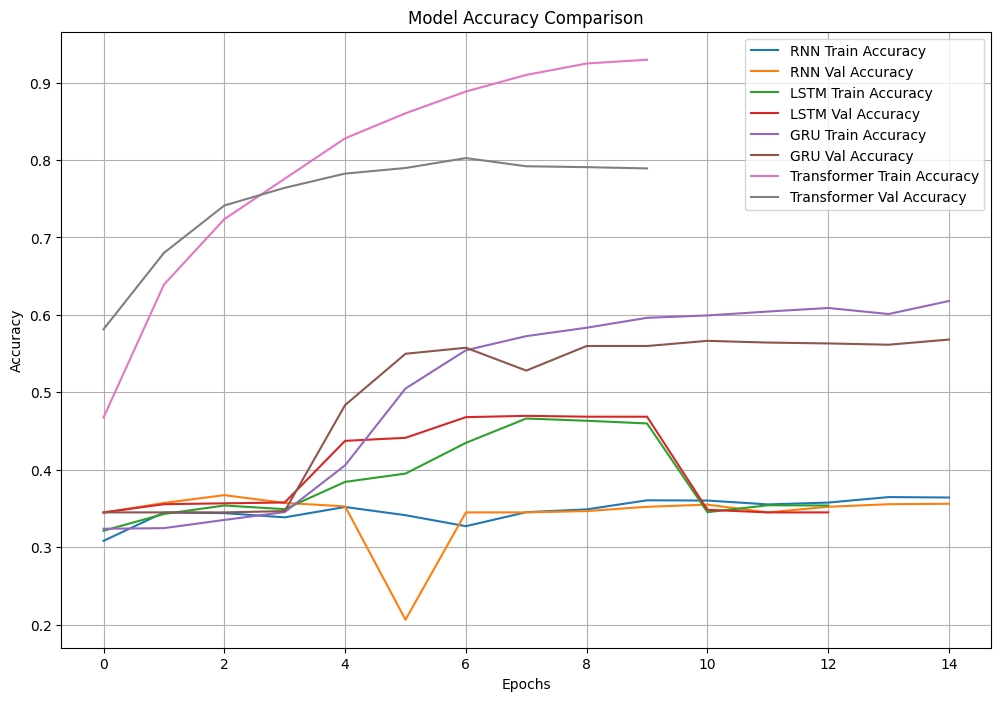

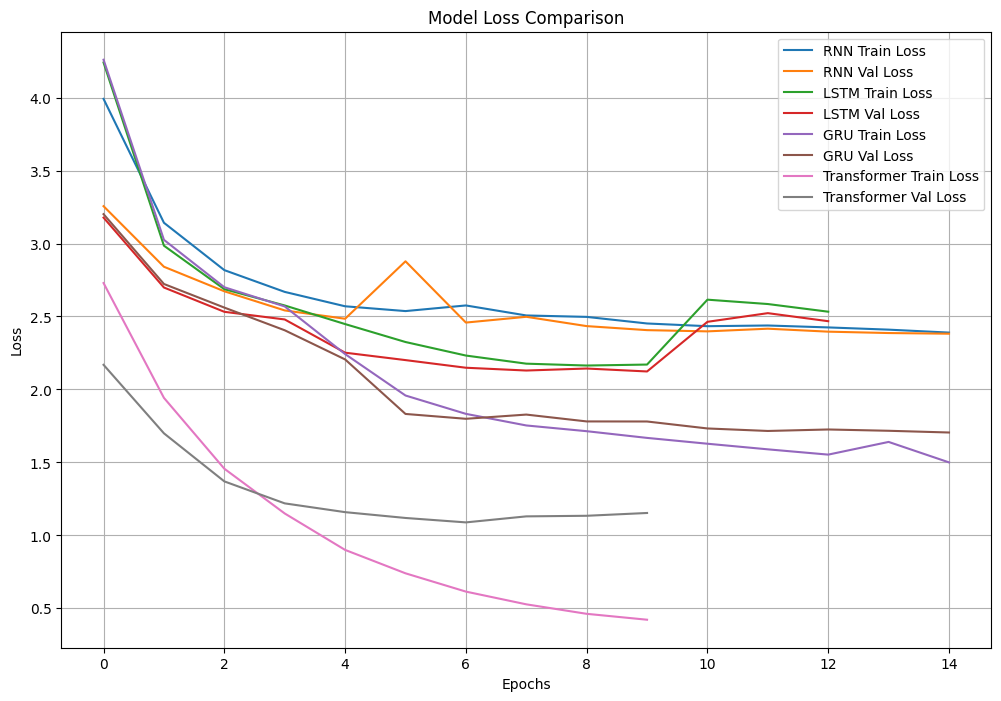

In [46]:
# Visualize learning curves
plot_learning_curves(histories)


In [31]:
# Display scores
display_scores(scores)



RNN Model Performance:
  - Test Loss: 2.3155980110168457
  - Test Accuracy: 0.3802315294742584
  - Precision: 0.0
  - Recall: 0.0

LSTM Model Performance:
  - Test Loss: 1.545082688331604
  - Test Accuracy: 0.6478183269500732
  - Precision: 0.8701563477516174
  - Recall: 0.5699020624160767

GRU Model Performance:
  - Test Loss: 1.4684643745422363
  - Test Accuracy: 0.6691896915435791
  - Precision: 0.8780012726783752
  - Recall: 0.6024042963981628

Transformer Model Performance:
  - Test Loss: 0.8531920313835144
  - Test Accuracy: 0.8040961623191833
  - Precision: 0.8799999952316284
  - Recall: 0.754229724407196
